In [2]:
%pylab
%matplotlib inline
from PIL import Image
from PIL import ImageFilter
from scipy.ndimage.filters import gaussian_filter, gaussian_gradient_magnitude

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


Let's load up an image with PIL and take a look at it and PIL's edge detect result.

In [5]:
img = Image.open("/home/mike/Pictures/duck.jpg")
img.show()
img.filter(ImageFilter.FIND_EDGES).show()

Alright, now we're gonna roll our own a few different ways.

In [50]:
imgdata = np.array(img.convert('L').getdata()).reshape(img.size) # get a nice grayscale 2D array

First we'll just compute the numerical gradient of the smoothed image and take its magnitude. Then we threshold the magnitude.

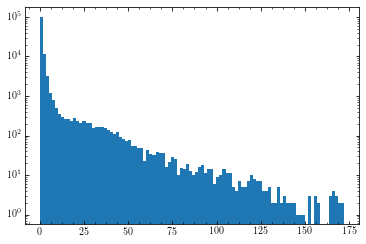

In [51]:
imdata = gaussian_filter(imgdata, 1)
gradx, grady = np.gradient(imgdata)
grad = np.sqrt(gradx**2 + grady**2)
plt.hist(grad.flatten(),100)
plt.yscale('log')
plt.show()

Let's set our threshold to 10 and see how that looks.

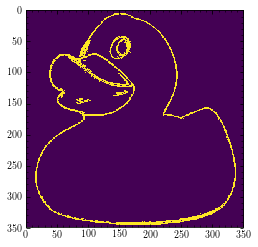

In [52]:
plt.imshow(grad>10)
plt.show()

Not bad, but definitely noisy. Let's try again, this time with a function that does everything for us, and pre-smooths the data with a larger smoothing parameter. Then we'll try a variety of smoothing parameters and thresholds.

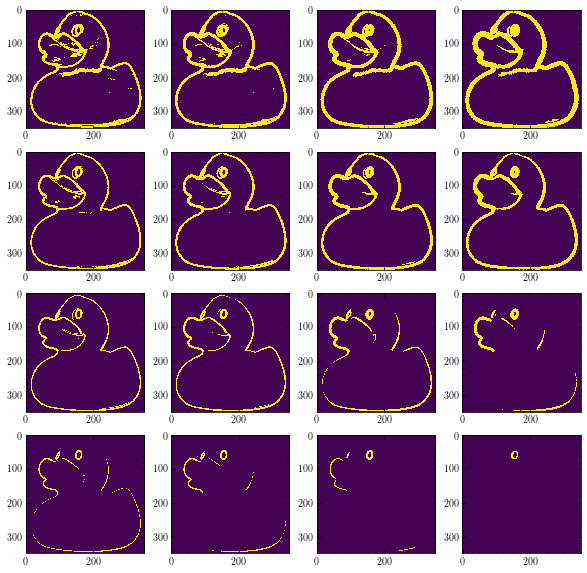

In [55]:
def GradEdgeDetect(data, threshold=10, smoothing=3):
    imgdata = np.copy(data)
    imgdata = gaussian_filter(imgdata, smoothing)
    gradx, grady = np.gradient(imgdata)
    grad = np.sqrt(gradx**2 + grady**2)
    return grad > threshold

fig, axes = plt.subplots(4, 4, figsize=(10,10))
smoothings = (1.5,2,3,4)
thresholds = (2,4,8,16)

for i in range(len(smoothings)):
    for j in range(len(smoothings)):
        axes[i,j].imshow(GradEdgeDetect(imgdata, smoothing=smoothings[j], threshold = thresholds[i]))
plt.show()

Fine, I guess, but it doesn't seem very robust, requiring very careful choice of smoothing and threshold. How about using the built-in gaussian gradient magnitude?

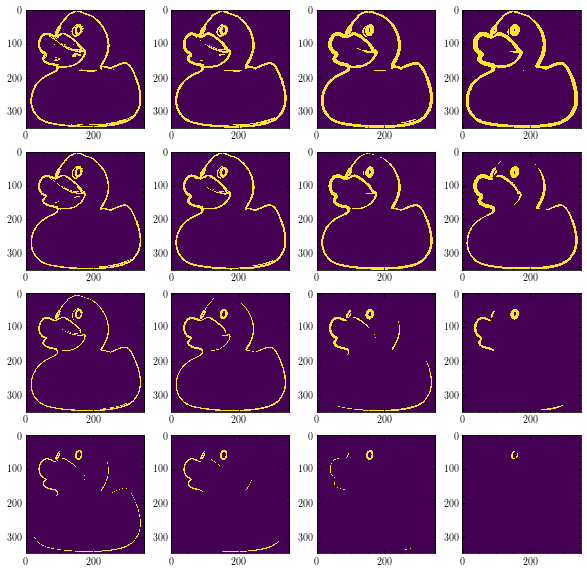

In [57]:
def GaussianGradEdgeDetect(data, threshold=10, smoothing=3):
    imgdata = np.copy(data)
    grad = gaussian_gradient_magnitude(imgdata, smoothing)
    #gradx, grady = np.gradient(imgdata)
    #grad = np.sqrt(gradx**2 + grady**2)
    return grad > threshold

fig, axes = plt.subplots(4, 4, figsize=(10,10))
smoothings = (1.5,2,3,4)
thresholds = (2,4,8,16)

for i in range(len(smoothings)):
    for j in range(len(smoothings)):
        axes[i,j].imshow(GaussianGradEdgeDetect(imgdata, smoothing=smoothings[j], threshold = thresholds[i]))
plt.show()

Maybe a bit better but I'm still not thrilled. What if we were to fit the neighbourhood of each point to a 2D step function of arbitrary orientation + a constant, and then call it an "edge" when the value of the step has a certain significance level?